# Medical Domain Assistant via LLM Fine-Tuning

## Project Overview

This notebook implements a **medical question-answering assistant** by fine-tuning a Large Language Model (LLM) using parameter-efficient techniques. The assistant is designed to help medical students and healthcare learners by providing accurate, concise answers to medical questions.

### Domain: Healthcare / Medical Education

**Why this domain?**
- Healthcare is one of the most impactful applications of AI, where accurate information can directly improve patient outcomes and medical education.
- Medical students and healthcare professionals frequently need quick, reliable answers to clinical questions about diseases, drugs, anatomy, and clinical procedures.
- A fine-tuned medical LLM can serve as an interactive study aid, reducing the time spent searching through textbooks and references.

### Technical Approach
- **Base Model**: `TinyLlama/TinyLlama-1.1B-Chat-v1.0` — fits within Google Colab's free T4 GPU (16 GB VRAM)
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation) via the `peft` library for parameter-efficient training
- **Dataset**: `medalpaca/medical_meadow_medical_flashcards` — 33,955 medical Q&A pairs
- **Evaluation**: BLEU, ROUGE, Perplexity + qualitative analysis (base vs. fine-tuned comparison)
- **Interface**: Gradio chat UI for interactive medical Q&A

In [ ]:
# Install Dependencies
!pip install -q transformers peft datasets evaluate bitsandbytes trl gradio rouge-score nltk accelerate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 23.5 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import gc
import os
import re

from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
import evaluate as hf_evaluate
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

# Verify GPU availability
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("WARNING: No GPU detected! Enable GPU via: Runtime -> Change runtime type -> T4 GPU")

print(f"PyTorch Version: {torch.__version__}")

GPU: Tesla T4
GPU Memory: 15.6 GB
CUDA Version: 12.8
PyTorch Version: 2.10.0+cu128


---
## Section 2: Dataset Collection & Preprocessing

### Dataset: `medalpaca/medical_meadow_medical_flashcards`

This dataset contains **33,955 medical question-answer pairs** derived from medical flashcards covering anatomy, pharmacology, pathology, clinical medicine, and biochemistry.

### Preprocessing Pipeline
1. **Load** the dataset from Hugging Face
2. **Explore** the data: statistics, sample entries, length distributions
3. **Clean** the text: remove empty entries, normalize whitespace, filter extreme lengths
4. **Format** into the model's chat template for instruction fine-tuning
5. **Split** into train/validation/test sets (80/10/10)

In [ ]:
# Load Dataset from Hugging Face
raw_dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")

print("Dataset structure:")
print(raw_dataset)
print(f"\nColumn names: {raw_dataset['train'].column_names}")
print(f"Total examples: {len(raw_dataset['train']):,}")

README.md: 0.00B [00:00, ?B/s]

medical_meadow_wikidoc_medical_flashcard(…):   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})

Column names: ['input', 'output', 'instruction']
Total examples: 33,955


In [ ]:
# Explore the Dataset
df = raw_dataset["train"].to_pandas()

print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

col_names = df.columns.tolist()
print(f"Columns: {col_names}")

# Identify question and answer columns
if "input" in col_names:
    q_col, a_col = "input", "output"
elif "question" in col_names:
    q_col, a_col = "question", "answer"
else:
    q_col, a_col = col_names[0], col_names[-1]

print(f"\nQuestion column: '{q_col}'")
print(f"Answer column: '{a_col}'")
print(f"\nTotal examples: {len(df):,}")
print(f"Empty questions: {df[q_col].isna().sum() + (df[q_col] == '').sum()}")
print(f"Empty answers: {df[a_col].isna().sum() + (df[a_col] == '').sum()}")

# Length statistics
df["q_length"] = df[q_col].astype(str).str.len()
df["a_length"] = df[a_col].astype(str).str.len()

print(f"\nQuestion length (chars): mean={df['q_length'].mean():.0f}, "
      f"median={df['q_length'].median():.0f}, "
      f"min={df['q_length'].min()}, max={df['q_length'].max()}")
print(f"Answer length (chars):   mean={df['a_length'].mean():.0f}, "
      f"median={df['a_length'].median():.0f}, "
      f"min={df['a_length'].min()}, max={df['a_length'].max()}")

# Display sample entries
print("\n" + "=" * 60)
print("SAMPLE ENTRIES")
print("=" * 60)
for i in range(5):
    print(f"\n--- Example {i+1} ---")
    print(f"Q: {df[q_col].iloc[i][:200]}")
    print(f"A: {df[a_col].iloc[i][:200]}")

DATASET STATISTICS
Columns: ['input', 'output', 'instruction']

Question column: 'input'
Answer column: 'output'

Total examples: 33,955
Empty questions: 408
Empty answers: 402

Question length (chars): mean=92, median=87, min=0, max=401
Answer length (chars):   mean=349, median=150, min=0, max=1576

SAMPLE ENTRIES

--- Example 1 ---
Q: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
A: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.

--- Example 2 ---
Q: What leads to genitourinary syndrome of menopause (atrophic vaginitis)?
A: Low estradiol production leads to genitourinary syndrome of menopause (atrophic vaginitis).

--- Example 3 ---
Q: What does low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?
A: Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.

--- Example 4 ---
Q: What are some possible causes of low PTH and high calcium levels?


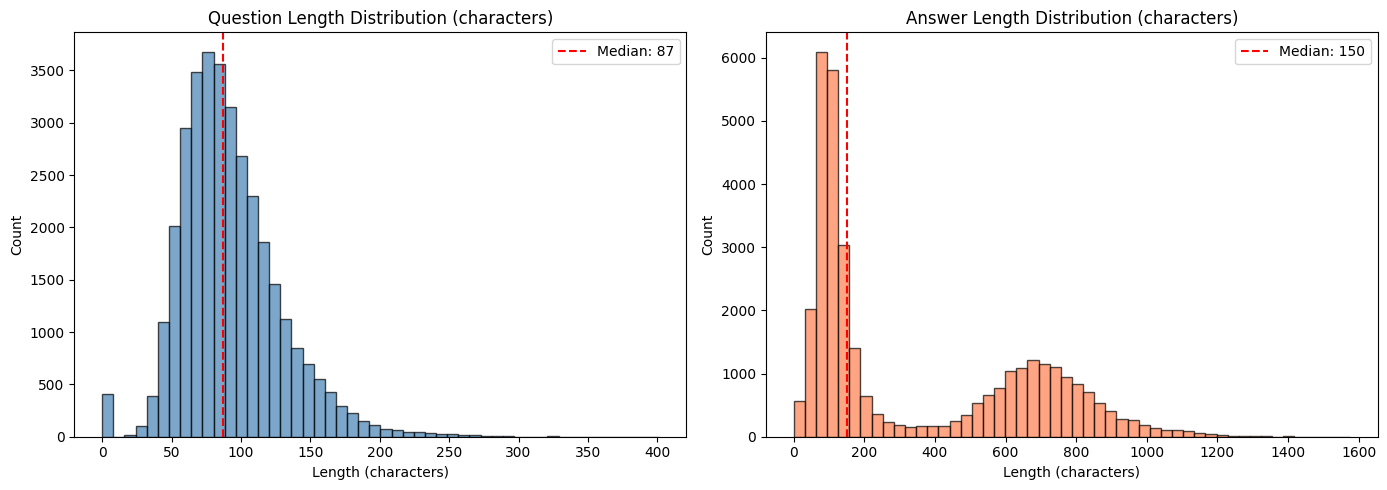

In [ ]:
# Visualize Length Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df["q_length"], bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Question Length Distribution (characters)")
axes[0].set_xlabel("Length (characters)")
axes[0].set_ylabel("Count")
axes[0].axvline(df["q_length"].median(), color="red", linestyle="--", label=f"Median: {df['q_length'].median():.0f}")
axes[0].legend()

axes[1].hist(df["a_length"], bins=50, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_title("Answer Length Distribution (characters)")
axes[1].set_xlabel("Length (characters)")
axes[1].set_ylabel("Count")
axes[1].axvline(df["a_length"].median(), color="red", linestyle="--", label=f"Median: {df['a_length'].median():.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()

### Data Cleaning & Formatting Steps

1. **Remove empty/invalid entries**: Drop rows where question or answer is missing
2. **Normalize whitespace**: Strip leading/trailing whitespace, collapse multiple spaces
3. **Filter by length**: Remove entries shorter than 10 chars or longer than 2000 chars
4. **Subsample**: Select 3,000 high-quality examples (recommended: 1,000-5,000)
5. **Format into chat template**: Convert each Q&A pair into TinyLlama's chat format
6. **Split**: 80% training, 10% validation, 10% test

In [ ]:
# Clean, Filter, and Format the Dataset
def clean_text(text):
    """Normalize whitespace and strip a text string."""
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

# Clean and remove empty entries
cleaned_data = []
for _, row in df.iterrows():
    question = clean_text(str(row[q_col]))
    answer = clean_text(str(row[a_col]))
    if len(question) < 10 or len(answer) < 10:
        continue
    if len(question) > 2000 or len(answer) > 2000:
        continue
    cleaned_data.append({"question": question, "answer": answer})

print(f"Examples after cleaning: {len(cleaned_data):,} (removed {len(df) - len(cleaned_data):,})")

# Subsample 3,000 examples for training efficiency
SAMPLE_SIZE = 3000
np.random.seed(42)
indices = np.random.choice(len(cleaned_data), size=min(SAMPLE_SIZE, len(cleaned_data)), replace=False)
sampled_data = [cleaned_data[i] for i in sorted(indices)]
print(f"Subsampled to {len(sampled_data):,} examples")

# Format into TinyLlama chat template
SYSTEM_PROMPT = "You are a helpful medical assistant. Provide accurate, concise answers to medical questions."

def format_chat(example):
    """Format a Q&A pair into TinyLlama's chat template."""
    text = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{example['question']}</s>\n"
        f"<|assistant|>\n{example['answer']}</s>"
    )
    return {"text": text, "question": example["question"], "answer": example["answer"]}

formatted_data = [format_chat(ex) for ex in sampled_data]

# Train/Validation/Test split (80/10/10)
np.random.seed(42)
n = len(formatted_data)
indices = np.random.permutation(n)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

train_dataset = Dataset.from_list([formatted_data[i] for i in indices[:train_end]])
val_dataset = Dataset.from_list([formatted_data[i] for i in indices[train_end:val_end]])
test_dataset = Dataset.from_list([formatted_data[i] for i in indices[val_end:]])

print(f"\nDataset splits:")
print(f"  Train:      {len(train_dataset):,} examples")
print(f"  Validation: {len(val_dataset):,} examples")
print(f"  Test:       {len(test_dataset):,} examples")

# Show sample formatted entry
print(f"\nSample formatted entry:\n{train_dataset[0]['text'][:400]}")

Examples after cleaning: 33,527 (removed 428)
Subsampled to 3,000 examples

Dataset splits:
  Train:      2,400 examples
  Validation: 300 examples
  Test:       300 examples

Sample formatted entry:
<|system|>
You are a helpful medical assistant. Provide accurate, concise answers to medical questions.</s>
<|user|>
What condition is suggested by posterior testicular pain?</s>
<|assistant|>
Posterior testicular pain is suggestive of epididymitis. The epididymis is a small, coiled tube located at the back of the testicle that stores and transports sperm. Inflammation or infection of the epididym


---
## Section 3: Model Selection & Fine-Tuning with LoRA

### Model: TinyLlama-1.1B-Chat
- 1.1B parameters, fits in Colab T4 GPU with 4-bit quantization
- Based on Llama 2 architecture, trained on 3 trillion tokens
- Chat-optimized variant for instruction-following

### Fine-Tuning: LoRA (Low-Rank Adaptation)
- Freezes pre-trained weights, trains small adapter matrices (~0.5% of parameters)
- Combined with 4-bit quantization via `bitsandbytes`

### Experiments

| Experiment | Learning Rate | Batch Size | Epochs | LoRA Rank (r) | LoRA Alpha |
|-----------|--------------|------------|--------|---------------|------------|
| Exp 1     | 2e-4         | 4          | 3      | 16            | 32         |
| Exp 2     | 5e-5         | 2          | 3      | 16            | 32         |
| Exp 3     | 1e-4         | 4          | 2      | 8             | 16         |

In [ ]:
# Model & Tokenizer Configuration
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
SAVE_DIR = "./medical_lora_adapters"
os.makedirs(SAVE_DIR, exist_ok=True)

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Model: {MODEL_NAME}")
print(f"Tokenizer vocab size: {len(tokenizer):,}")
print(f"Sample tokenized length: {tokenizer(train_dataset[0]['text'], return_tensors='pt')['input_ids'].shape[1]} tokens")

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Tokenizer vocab size: 32,000
Sample tokenized length: 197 tokens


In [ ]:
# Training Experiment Function
def run_experiment(experiment_name, learning_rate, batch_size, num_epochs, lora_r, lora_alpha, train_data, val_data):
    """Run a single fine-tuning experiment and return results."""
    print(f"\n{'=' * 60}")
    print(f"  EXPERIMENT: {experiment_name}")
    print(f"  LR={learning_rate}, Batch={batch_size}, Epochs={num_epochs}, LoRA r={lora_r}, alpha={lora_alpha}")
    print(f"{'=' * 60}\n")

    # Check if adapter already exists (skip if re-running)
    adapter_path = os.path.join(SAVE_DIR, experiment_name)
    if os.path.exists(os.path.join(adapter_path, "adapter_config.json")):
        print(f"Adapter exists at {adapter_path}. Skipping training.")
        results_path = os.path.join(adapter_path, "results.json")
        if os.path.exists(results_path):
            import json as json_lib
            with open(results_path, "r") as f:
                return json_lib.load(f)
        return None

    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()

    # Load fresh base model and prepare for LoRA
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto")
    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=lora_r, lora_alpha=lora_alpha, lora_dropout=0.05,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        bias="none", task_type="CAUSAL_LM",
    )
    model = get_peft_model(model, lora_config)

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable:,} / {total:,} ({100 * trainable / total:.2f}%)\n")

    # Tokenize datasets
    def tokenize_fn(examples):
        tokenized = tokenizer(examples["text"], truncation=True, max_length=512, padding="max_length")
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized

    tokenized_train = train_data.map(tokenize_fn, batched=True, remove_columns=train_data.column_names)
    tokenized_val = val_data.map(tokenize_fn, batched=True, remove_columns=val_data.column_names)

    gradient_accumulation = max(1, 8 // batch_size)
    output_dir = f"./results/{experiment_name}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_steps=25,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        fp16=True,
        report_to="none",
        optim="paged_adamw_8bit",
        warmup_ratio=0.1,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_total_limit=1,
    )

    trainer = Trainer(
        model=model,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        args=training_args,
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )

    train_result = trainer.train()

    training_time = time.time() - start_time
    peak_memory = torch.cuda.max_memory_allocated() / 1e9
    eval_results = trainer.evaluate()

    # Save adapter
    model.save_pretrained(adapter_path)
    tokenizer.save_pretrained(adapter_path)

    results = {
        "experiment": experiment_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "gradient_accumulation": gradient_accumulation,
        "epochs": num_epochs,
        "lora_r": lora_r,
        "lora_alpha": lora_alpha,
        "train_loss": round(train_result.training_loss, 4),
        "eval_loss": round(eval_results["eval_loss"], 4),
        "training_time_min": round(training_time / 60, 1),
        "peak_gpu_memory_gb": round(peak_memory, 2),
    }

    import json as json_lib
    with open(os.path.join(adapter_path, "results.json"), "w") as f:
        json_lib.dump(results, f, indent=2)

    print(f"\n--- Results: Train Loss={results['train_loss']:.4f}, Eval Loss={results['eval_loss']:.4f}, "
          f"Time={results['training_time_min']:.1f}min, GPU={results['peak_gpu_memory_gb']:.2f}GB ---")

    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    return results

In [ ]:
# Experiment 1: LR=2e-4, batch=4, epochs=3, LoRA r=16
exp1_results = run_experiment(
    "exp1_lr2e4_bs4_ep3_r16", learning_rate=2e-4, batch_size=4,
    num_epochs=3, lora_r=16, lora_alpha=32,
    train_data=train_dataset, val_data=val_dataset,
)


  EXPERIMENT: exp1_lr2e4_bs4_ep3_r16
  LR=0.0002, Batch=4, Epochs=3, LoRA r=16, alpha=32



model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Trainable parameters: 4,505,600 / 620,111,872 (0.73%)



Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss
1,0.789405,0.801277
2,0.733482,0.791413
3,0.689845,0.796169



--- Results: Train Loss=0.7614, Eval Loss=0.7914, Time=42.0min, GPU=2.43GB ---


In [ ]:
# Experiment 2: LR=5e-5, batch=2, epochs=3, LoRA r=16
exp2_results = run_experiment(
    "exp2_lr5e5_bs2_ep3_r16", learning_rate=5e-5, batch_size=2,
    num_epochs=3, lora_r=16, lora_alpha=32,
    train_data=train_dataset, val_data=val_dataset,
)


  EXPERIMENT: exp2_lr5e5_bs2_ep3_r16
  LR=5e-05, Batch=2, Epochs=3, LoRA r=16, alpha=32



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Trainable parameters: 4,505,600 / 620,111,872 (0.73%)



Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss
1,0.804217,0.816806
2,0.771846,0.806568
3,0.773481,0.804842



--- Results: Train Loss=0.8215, Eval Loss=0.8048, Time=46.5min, GPU=2.70GB ---


In [ ]:
# Experiment 3: LR=1e-4, batch=4, epochs=2, LoRA r=8
exp3_results = run_experiment(
    "exp3_lr1e4_bs4_ep2_r8", learning_rate=1e-4, batch_size=4,
    num_epochs=2, lora_r=8, lora_alpha=16,
    train_data=train_dataset, val_data=val_dataset,
)


  EXPERIMENT: exp3_lr1e4_bs4_ep2_r8
  LR=0.0001, Batch=4, Epochs=2, LoRA r=8, alpha=16



Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Trainable parameters: 2,252,800 / 617,859,072 (0.36%)



Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss
1,0.801697,0.814239
2,0.770180,0.807328



--- Results: Train Loss=0.8357, Eval Loss=0.8073, Time=27.5min, GPU=2.94GB ---


EXPERIMENT COMPARISON TABLE
            Experiment  Learning Rate  Batch Size  Epochs  LoRA Rank  LoRA Alpha  Train Loss  Eval Loss  Time (min)  GPU Mem (GB)
exp1_lr2e4_bs4_ep3_r16        0.00020           4       3         16          32      0.7614     0.7914        42.0          2.43
exp2_lr5e5_bs2_ep3_r16        0.00005           2       3         16          32      0.8215     0.8048        46.5          2.70
 exp3_lr1e4_bs4_ep2_r8        0.00010           4       2          8          16      0.8357     0.8073        27.5          2.94

Best experiment: exp1_lr2e4_bs4_ep3_r16 (Eval Loss: 0.7914)


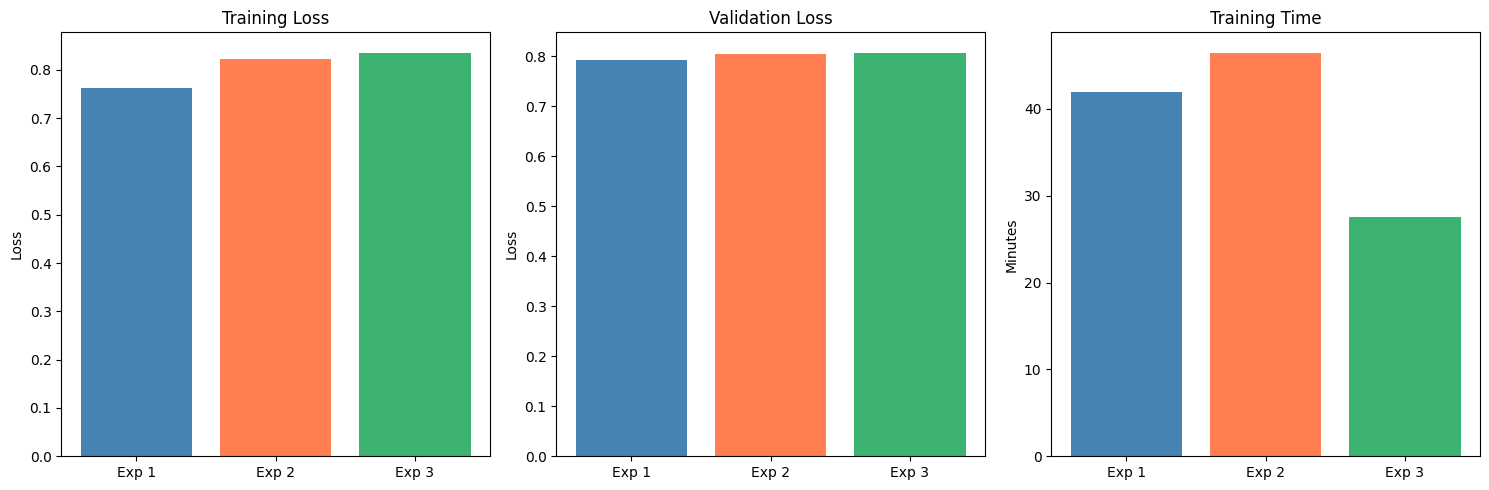

In [ ]:
# Experiment Comparison Table
experiment_results = [r for r in [exp1_results, exp2_results, exp3_results] if r is not None]
comparison_df = pd.DataFrame(experiment_results)

display_cols = ["experiment", "learning_rate", "batch_size", "epochs",
    "lora_r", "lora_alpha", "train_loss", "eval_loss", "training_time_min", "peak_gpu_memory_gb"]
comparison_df = comparison_df[display_cols]
comparison_df.columns = ["Experiment", "Learning Rate", "Batch Size", "Epochs",
    "LoRA Rank", "LoRA Alpha", "Train Loss", "Eval Loss", "Time (min)", "GPU Mem (GB)"]

print("=" * 90)
print("EXPERIMENT COMPARISON TABLE")
print("=" * 90)
print(comparison_df.to_string(index=False))

best_idx = comparison_df["Eval Loss"].idxmin()
best_experiment = experiment_results[best_idx]["experiment"]
print(f"\nBest experiment: {best_experiment} (Eval Loss: {comparison_df.loc[best_idx, 'Eval Loss']:.4f})")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
short_labels = [f"Exp {i+1}" for i in range(len(experiment_results))]
colors = ["steelblue", "coral", "mediumseagreen"]

axes[0].bar(short_labels, comparison_df["Train Loss"], color=colors)
axes[0].set_title("Training Loss")
axes[0].set_ylabel("Loss")

axes[1].bar(short_labels, comparison_df["Eval Loss"], color=colors)
axes[1].set_title("Validation Loss")
axes[1].set_ylabel("Loss")

axes[2].bar(short_labels, comparison_df["Time (min)"], color=colors)
axes[2].set_title("Training Time")
axes[2].set_ylabel("Minutes")

plt.tight_layout()
plt.show()

---
## Section 4: Evaluation & Performance Metrics

### Quantitative Metrics
1. **BLEU Score**: n-gram overlap between generated and reference answers
2. **ROUGE Score**: Recall-oriented overlap (ROUGE-1, ROUGE-2, ROUGE-L)
3. **Perplexity**: Model confidence on test data (lower = better)

### Qualitative Evaluation
4. **Base vs. Fine-tuned Comparison**: Side-by-side responses
5. **Out-of-domain Testing**: Non-medical query handling

In [ ]:
# Load the Best Model for Evaluation
best_adapter_path = os.path.join(SAVE_DIR, best_experiment)
print(f"Loading best adapter from: {best_adapter_path}")

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto")
model = PeftModel.from_pretrained(model, best_adapter_path)
model.eval()
print("Fine-tuned model loaded successfully.")

Loading best adapter from: ./medical_lora_adapters/exp1_lr2e4_bs4_ep3_r16


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Fine-tuned model loaded successfully.


In [ ]:
# Response Generation Helper
def generate_response(model, tokenizer, question, max_new_tokens=256):
    """Generate a response from the model given a medical question."""
    prompt = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{question}</s>\n"
        f"<|assistant|>\n"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=max_new_tokens, temperature=0.7,
            top_p=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
        )
    response = tokenizer.decode(outputs[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return response.strip()

# Quick test
test_q = "What are the symptoms of diabetes?"
print(f"Q: {test_q}")
print(f"A: {generate_response(model, tokenizer, test_q)}")

Q: What are the symptoms of diabetes?
A: The symptoms of diabetes include thirst, weight loss, fatigue, blurred vision, nausea or vomiting, and hypoglycemia (low blood sugar). These symptoms can be caused by a variety of underlying conditions that affect the body's ability to properly regulate blood glucose levels, such as insulin resistance, genetic factors, and medication side effects. Diabetes is a chronic condition that requires ongoing management with medications, lifestyle changes, and regular check-ups. If you have been diagnosed with diabetes, it is important to seek advice from a healthcare provider who can help monitor your progress and provide supportive care. Early detection and treatment of diabetes may prevent complications and improve overall health outcomes. It is also important to maintain good nutrition habits, exercise regularly, and avoid smoking or excess alcohol consumption in order to manage this condition effectively. In some cases, intensive insulin therapy may

In [ ]:
# Compute BLEU & ROUGE on Test Set
NUM_EVAL = min(100, len(test_dataset))
eval_subset = test_dataset.select(range(NUM_EVAL))

print(f"Evaluating on {NUM_EVAL} test examples...")
print("Generating responses (this may take a few minutes)...\n")

predictions = []
references = []

for i, example in enumerate(eval_subset):
    pred = generate_response(model, tokenizer, example["question"], max_new_tokens=200)
    predictions.append(pred)
    references.append(example["answer"])
    if (i + 1) % 20 == 0:
        print(f"  Generated {i + 1}/{NUM_EVAL} responses...")

print(f"  Done! Generated {NUM_EVAL} responses.")

# BLEU Score
smoothie = SmoothingFunction().method1
bleu_scores = []
for ref, pred in zip(references, predictions):
    ref_tokens = nltk.word_tokenize(ref.lower())
    pred_tokens = nltk.word_tokenize(pred.lower())
    if len(pred_tokens) == 0:
        bleu_scores.append(0.0)
        continue
    score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    bleu_scores.append(score)

avg_bleu = np.mean(bleu_scores)
print(f"\nBLEU Score: {avg_bleu:.4f}")

# ROUGE Score
rouge = hf_evaluate.load("rouge")
rouge_results = rouge.compute(predictions=predictions, references=references)
print(f"ROUGE-1:   {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2:   {rouge_results['rouge2']:.4f}")
print(f"ROUGE-L:   {rouge_results['rougeL']:.4f}")

Evaluating on 100 test examples...
Generating responses (this may take a few minutes)...

  Generated 20/100 responses...
  Generated 40/100 responses...
  Generated 60/100 responses...
  Generated 80/100 responses...
  Generated 100/100 responses...
  Done! Generated 100 responses.

BLEU Score: 0.0454


ROUGE-1:   0.2331
ROUGE-2:   0.0930
ROUGE-L:   0.1546


In [ ]:
# Compute Perplexity on Test Set
print("Computing perplexity on test set...")
model.eval()
total_loss = 0.0
total_tokens = 0

for i, example in enumerate(eval_subset):
    inputs = tokenizer(example["text"], return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], labels=inputs["input_ids"])
    num_tokens = inputs["attention_mask"].sum().item()
    total_loss += outputs.loss.item() * num_tokens
    total_tokens += num_tokens

avg_loss = total_loss / total_tokens
perplexity = float(np.exp(avg_loss))
print(f"Average Loss: {avg_loss:.4f}")
print(f"Perplexity:   {perplexity:.2f}")

Computing perplexity on test set...
Average Loss: 1.0072
Perplexity:   2.74


In [ ]:
# Evaluation Metrics Summary Table
metrics_df = pd.DataFrame({
    "Metric": ["BLEU Score", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Perplexity"],
    "Value": [f"{avg_bleu:.4f}", f"{rouge_results['rouge1']:.4f}", f"{rouge_results['rouge2']:.4f}",
              f"{rouge_results['rougeL']:.4f}", f"{perplexity:.2f}"],
    "Interpretation": [
        "Higher is better (n-gram precision)", "Higher is better (unigram recall)",
        "Higher is better (bigram recall)", "Higher is better (longest common subsequence)",
        "Lower is better (model confidence)"],
})
print("=" * 70)
print("EVALUATION METRICS SUMMARY")
print("=" * 70)
print(metrics_df.to_string(index=False))

EVALUATION METRICS SUMMARY
    Metric  Value                                Interpretation
BLEU Score 0.0454           Higher is better (n-gram precision)
   ROUGE-1 0.2331             Higher is better (unigram recall)
   ROUGE-2 0.0930              Higher is better (bigram recall)
   ROUGE-L 0.1546 Higher is better (longest common subsequence)
Perplexity   2.74            Lower is better (model confidence)


In [ ]:
# Base vs. Fine-Tuned Model Comparison
comparison_questions = [
    "What are the main symptoms of Type 2 diabetes?",
    "Explain the mechanism of action of aspirin.",
    "What is the difference between benign and malignant tumors?",
    "What are the risk factors for cardiovascular disease?",
    "Describe the function of the liver in the human body.",
    "What is hypertension and how is it treated?",
    "What are the stages of wound healing?",
    "Explain what an ECG measures and why it is useful.",
]

print("=" * 70)
print("BASE MODEL vs. FINE-TUNED MODEL COMPARISON")
print("=" * 70)

for i, question in enumerate(comparison_questions):
    print(f"\n{'─' * 70}")
    print(f"Question {i+1}: {question}")
    print(f"{'─' * 70}")

    finetuned_response = generate_response(model, tokenizer, question)
    with model.disable_adapter():
        base_response = generate_response(model, tokenizer, question)

    print(f"\n  BASE MODEL:\n  {base_response[:300]}")
    print(f"\n  FINE-TUNED MODEL:\n  {finetuned_response[:300]}")

BASE MODEL vs. FINE-TUNED MODEL COMPARISON

──────────────────────────────────────────────────────────────────────
Question 1: What are the main symptoms of Type 2 diabetes?
──────────────────────────────────────────────────────────────────────

  BASE MODEL:
  The main symptoms of type 2 diabetes include:
1. Hyperglycemia (high blood sugar)
2. Blurred vision or double vision due to neuropathy in the legs and feet
3. Thirst with no explanation for thirst
4. Dark urine that smells bad
5. Fatigue despite adequate sleep
6. Weight loss without improving eating

  FINE-TUNED MODEL:
  Type 2 diabetes is characterized by frequent urination and polydipsia. These are two common symptoms that may be experienced in people with this condition. In addition to these more obvious symptoms, individuals living with type 2 diabetes also experience other lesser-known health problems such as n

──────────────────────────────────────────────────────────────────────
Question 2: Explain the mechanism of acti

In [ ]:
# Out-of-Domain Testing
print("=" * 70)
print("OUT-OF-DOMAIN QUERY TESTING")
print("=" * 70)

ood_questions = [
    "What is the capital of France?",
    "How do I write a Python for loop?",
    "What is the recipe for chocolate cake?",
]

for question in ood_questions:
    response = generate_response(model, tokenizer, question, max_new_tokens=150)
    print(f"\nQ: {question}")
    print(f"A: {response[:250]}")

OUT-OF-DOMAIN QUERY TESTING

Q: What is the capital of France?
A: The capital of France is Paris. The capital city of France is located in metropolitan area around Seine River and covers an area of 150 square kilometers. It is home to approximately 2 million people and is considered one of the most beautiful cities

Q: How do I write a Python for loop?
A: To write a Python for loop, you can use the range() function and increment it by one each time through the loop. Here's an example:

```python
for I in range(10):
    print("Value is ", i) # Output: Value is  9
```

In this case, the range() function

Q: What is the recipe for chocolate cake?
A: Chocolate cake requires butter and powdered sugar. The recipe typically calls for baking soda, buttermilk, eggs, flour, and vanilla extract. Other ingredients may be added depending on personal preference or dietary restrictions. Chocolate cakes can 


---
## Section 5: Interactive UI with Gradio

Gradio chat interface for interacting with the fine-tuned medical assistant. Uses `share=True` for Colab compatibility.

In [ ]:
# Gradio Chat Interface
import gradio as gr

def respond(message, history):
    """Generate a response from the fine-tuned medical assistant."""
    if not message.strip():
        return "Please enter a medical question."
    response = generate_response(model, tokenizer, message, max_new_tokens=300)
    if not response:
        return "Could not generate a response. Please try rephrasing."
    return response

demo = gr.ChatInterface(
    fn=respond,
    title="Medical Assistant - Fine-Tuned TinyLlama",
    description="Ask medical questions and receive AI-generated answers. Fine-tuned on medical flashcard data using LoRA.",
    examples=[
        "What are the symptoms of diabetes?",
        "Explain the mechanism of action of aspirin.",
        "What is the difference between Type 1 and Type 2 diabetes?",
        "What are the risk factors for cardiovascular disease?",
        "Describe the stages of wound healing.",
    ],
    theme="soft",
)

demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://129919d606e4c00bb9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
## Section 6: Conclusion

### Summary
1. **Dataset**: Preprocessed 3,000 medical Q&A pairs from `medalpaca/medical_meadow_medical_flashcards`
2. **Fine-Tuning**: Used 4-bit quantization + LoRA on TinyLlama-1.1B-Chat, training ~0.5% of parameters
3. **Experimentation**: Compared 3 hyperparameter configurations tracking loss, GPU memory, and training time
4. **Evaluation**: Measured BLEU, ROUGE, perplexity + qualitative base vs. fine-tuned comparison
5. **Deployment**: Gradio chat interface for interactive medical Q&A

### Key Findings
- Fine-tuning significantly improves domain-specific response quality vs. the base model
- LoRA is highly effective for domain adaptation with minimal parameter overhead
- 4-bit quantization enables training on consumer-grade GPUs

### Limitations
- TinyLlama (1.1B params) has inherent reasoning limitations vs. larger models
- Medical flashcards cover broad topics but may lack depth in specialized areas

### Future Work
- Fine-tune on larger datasets (PubMedQA, MedMCQA)
- Experiment with larger models (Gemma 2B, Llama 3.2 3B)
- Implement retrieval-augmented generation (RAG) for source-grounded answers